In [1]:
import csv
import codecs
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import string
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
import numpy as np
import nltk
from nltk.corpus import stopwords
from datetime import datetime

De la libreria nltk descarga los 'stopwords' para usarlos en la nube de palabras

In [2]:
nltk.download("stopwords")
stopwords = set(stopwords.words('spanish', 'english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mjavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Archivo Imagenes Clasificadas 

Abrimos el 'etiquetas.csv' con la libreria pandas, que nos permite leer el archivo como un data frame

In [3]:
archivo_etiquetas= "etiquetas.csv"
data_set = pd.read_csv(archivo_etiquetas, encoding='latin-1')

## (1) Tipo de Imagenes que se Utilizaron

Se busca en 'data_set' la columna "Tipo" donde esta almacenado en que formato se guardo cada imagen.

En una variable 'tipo_img' de tipo pandas, se guardan en el 'index' el tipo de imagen y en 'values' con que frecuencia aparecieron en el data frame.Guardando posteriormente ambos en dos variables 

In [4]:
tipo_img = data_set["Tipo"].value_counts()
etiquetas = list(tipo_img.index)
data_img = list(tipo_img.values)

A partir de la informacion anteriormente obtenida se genera el grafico. 

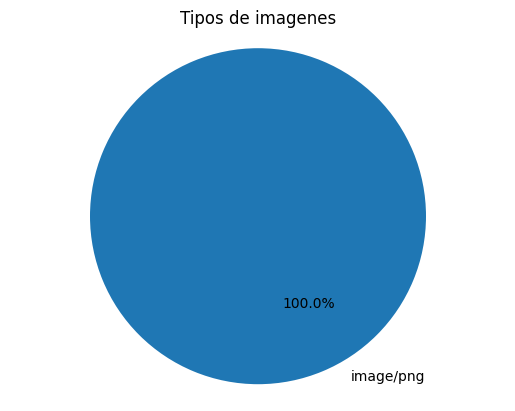

In [5]:
plt.pie(data_img, labels=etiquetas, autopct='%1.1f%%',
        startangle=120, labeldistance= 1.1)
plt.axis('equal')
plt.title("Tipos de imagenes")
plt.show()

## (2) Valor Maximo del Alto y Ancho de las Resoluciones de Imagenes Clasificadas 

### Ancho Maximo

Para determinar tanto el maximo ancho como alto se crea a partir de la columna de 'Recolucion' un lista de las resoluciones de la forma 'ancho x alto'. 

De esta lista se terminea el maximo valor con una funcion max e iterando sobre todos los elementos realizando un split, donde el elemento en posicion '0' va a ser el ancho, y '1' el alto. 

In [6]:
tamanio = list(data_set["Resolucion"].values)
print(tamanio)

ancho = max(int(elemento.split("x")[0].strip()) for elemento in tamanio)
print("Maximo ancho:", ancho , "px")

['71 x 64', '88 x 64', '71 x 64', '462 x 260', '384 x 295', '408 x 374', '71 x 64', '360 x 303', '450 x 346', '500 x 327', '432 x 421', '440 x 319']
Maximo ancho: 500 px


### Altura Maxima

In [7]:
altura = max(int(elemento.split("x")[1].strip()) for elemento in tamanio)
print("Maximo Alto:", altura , "px")

Maximo Alto: 421 px


## (3) Grafico de Dispercion entre Ancho y Alto.  

Se crean 2 lista, una donde esta el ancho de todas las resoluciones y otra con la Altura. 

In [8]:
data_ancho = list(int(elem.split("x")[0].strip()) for elem in tamanio)
data_alto = list(int(elem.split("x")[1].strip()) for elem in tamanio)

Para crear el grafico se ingresan las listas ordenadas como ejes X e Y. 

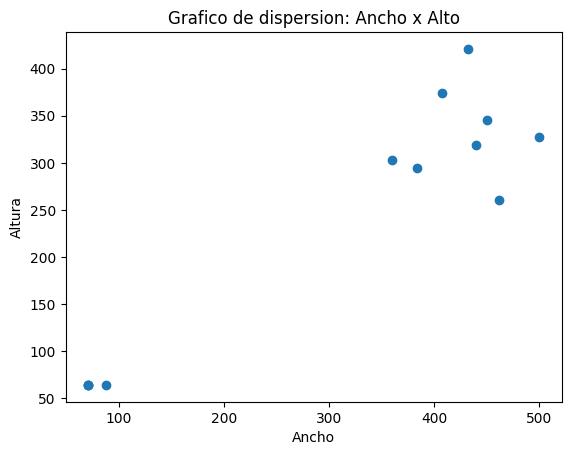

In [9]:
plt.scatter(data_ancho, data_alto)
plt.xlabel("Ancho")
plt.ylabel("Altura")
plt.title("Grafico de dispersion: Ancho x Alto")
plt.show()

## (4) Cantidad de Cambios Realizados para cada Dia de la Semana

Para obtener los cambios realizados en cada dia de la semana seleccionamos del Data Frame la columa "Fecha de Ultima Actualizacion"

A partir del metodo "to_datetime" de pandas se obitenen las fechas en formado datetime y de esa forma se accede a cada dia de la semana. Almacenandoce en data_fecha["Dia Semana"]

In [10]:
data_fecha = data_set["Fecha de Ultima Actualizacion"]
fecha_datetime = pd.to_datetime(data_fecha, unit = 's')
fecha_datetime["Dia Semana"] = fecha_datetime.dt.day_name()

Se crea una lista de todos los dias de la semana los cuales se le asignan al index de un nuevo Data Frame llamado 'set_completo'. 

se crea una columna 'Frecuencias' donde muestra con que frecuencia aparece cada dia y aquellos valores que no aparezca se llenen con valor = 0. 

In [11]:
etiquetas_dias = ["Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday"]

data_dias = fecha_datetime["Dia Semana"].value_counts()

In [12]:
set_completo = pd.DataFrame(index = etiquetas_dias) 

set_completo["Frecuencia"] = data_dias.reindex(etiquetas_dias, fill_value = 0)

Se crea el grafico de barras, ingresando los datos del Data Frame 'set_compelto. 

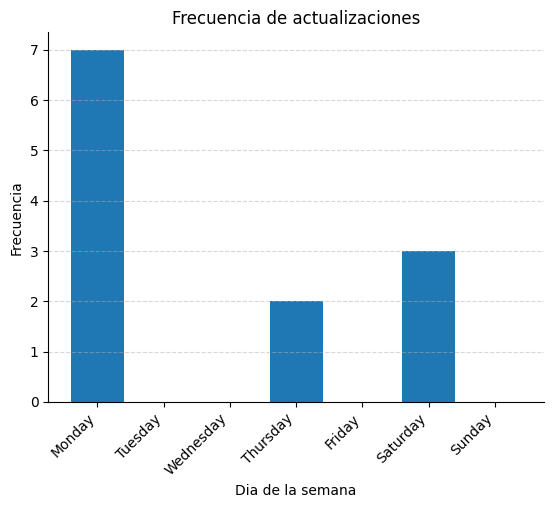

In [13]:
plt.bar(set_completo.index, set_completo["Frecuencia"])

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(rotation = 45, ha = 'right')

plt.xlabel("Dia de la semana")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de actualizaciones")

plt.show()

## (5) Evolucion de la Cantidad de Actualizaciones 

Se obtienen las fechas de la columna del dataFrame 'Fecha de Ultima Actualizacion', donde se almacenan en formato datetime en la variable 'fecha_datetime' para luego obtener solo la fecha: dia, mes y año. 

In [14]:
data_fecha = data_set["Fecha de Ultima Actualizacion"]
fecha_datetime = pd.to_datetime(data_fecha, unit="s")
fechas = fecha_datetime.dt.date

Obtenemos la frecuencia con la que se repite cada fecha
Se crea una lista con dichas frecuencias (Eje Y)

In [15]:
df_fechas = fechas.value_counts(sort = False)

frecuencia_fechas = list(df_fechas.values)

Se ordena el los valores en datetime del dataframe.
Se crea una lista 'etiquetas' con las fechas en formato string. (Eje X). 

In [16]:
etiquetas_sorted = sorted(df_fechas.index)
etiquetas = [fecha.strftime("%d-%m-%Y") for fecha in etiquetas_sorted]

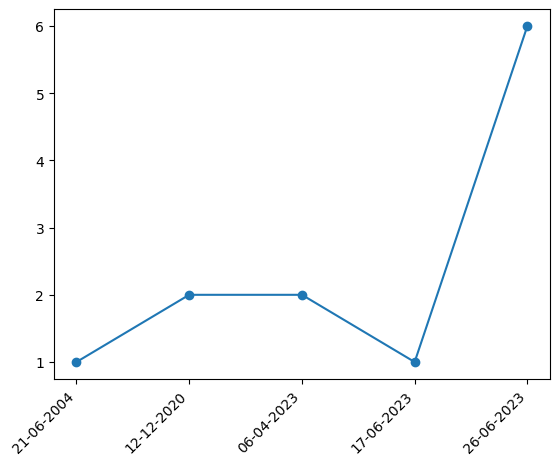

In [17]:
plt.xticks(rotation = 45, ha = 'right')
plt.plot(etiquetas, frecuencia_fechas, marker="o", linestyle = '-')

## (6) Nube de Palabras de Lista de Tags

A partir de la columna "Lista de Tags" de data_set. Se crea un Data Frame donde las columnas son las palabras segun la posicion y fila. Y se reemplazan algunos caracteres para dejar solo las palabras. 

In [18]:
data_nubes = data_set["Lista de Tags"].str.replace(r"[", "").str.replace(r"\'", "").str.replace(r"]", "").str.replace(r"'", "").str.split(",", expand=True)
data_nubes

,0,1,2,3,4
0,GATO,LINDO,NEKO,OWO,None
1,PERRO,GUAU,PICHICHO,None,None
2,LEON,REY,SIMBA,GATO,None
3,HOMBRE,ARAÑA,SPIDERMAN,None,None
4,MONO,MIEDO,TURBIO,None,None
5,FERNANFLOO,FERNAN,FACHA,None,None
6,TIGRE,MICHI,GRANDE,GATO,None
7,HAROLD,DOLOR,ESCONDER,None,None
8,DOGE,CHEEMS,FUERTE,DEBIL,PERRO
9,MATEMATICA,MIEDO,PESADILLA,None,None


Se crea una variable texto para ingresar en la nube de palabras y se recorre cada columna agregando el tag al string 'Texto'. 

Se reemplazas los None que se generaron en el Data Frame y se crea la nube de palabras 

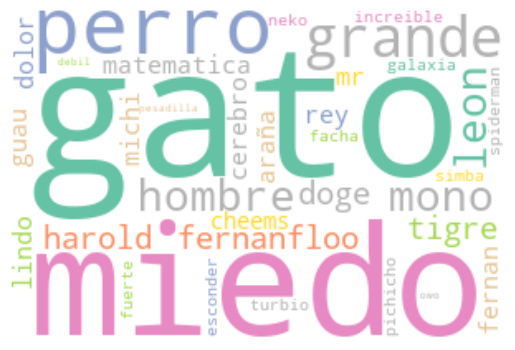

In [19]:
texto = ''
for col in data_nubes.columns:
    # Concatenar el texto de cada columna
    texto += ' '.join(data_nubes[col].astype(str).tolist()) + ' '
    
texto = texto.replace('None', '').lower()

wc = WordCloud(width = 300, height = 200, random_state=1,background_color='white', colormap='Set2', collocations=False, stopwords = stopwords).generate(texto)
plt.axis("off")
plt.imshow(wc, interpolation = "bilinear")

plt.show()

## (7) Tags Mas Utilizados

A partir de el Data Frame 'data_nubes' del ejercicio anterior, se crea un nuevo Data Frame al que llamaremos 'df' a partir del metodo 'melt' que permite juntar todas las columnas en una unica columna de otro Data Fram. 

In [20]:
df = pd.melt(data_nubes)

Se elimina la columna 'variable' y las filas en 'None'.

Luego se resetea el index del Data Frame

In [21]:
df = df.drop('variable', axis=1).dropna()
df = df.reset_index(drop=True) #reinicia los indices



Se saca la frecuencia con la que aparece cada tag y se cambia el nombre de las columnas. 

In [22]:
data_df = df.value_counts()
data_df = data_df.reset_index() #Se reinicia el indice que ya data_df.value_counts() devuelve un multipleIndex y no permite usarlo. 
data_df = data_df.rename(columns={"value":"Tags", "count":"Usos"})
data_df[:3]

,Tags,Usos
0,MIEDO,3
1,GRANDE,2
2,GATO,2


## (8) Tamaño en Byts Promedio

A partir del meto 'groupby' se agrupa por valor unico de 'Ultimo Perfil que Actualizo' y se calcula de la columna 'Tamanio' el promedio de Bytes con el metodo 'mean' para cada grupo. 

Se le cambia el nombre de las columnas al nuevo Data Frame (data_bytes). 

In [23]:
data_bytes = data_set.groupby('Ultimo Perfil que Actualizo')["Tamaño"].mean().reset_index()
data_bytes = data_bytes.rename(columns={"Ultimo Perfil que Actualizo":"Perfil", "Tamaño":"Tamaño promedio"})

data_bytes.sort_values(by = "Tamaño promedio", ascending = False).reset_index().drop("index", axis = 1)

,Perfil,Tamaño promedio
0,Xx_EPiK_xX,252.5010
1,pip,193.1550
2,pepegamer,131.1705
3,epicmari,106.4546
4,leyenda123,6.6255


-------------------------------------------------------------------------------------------------------------------------------

# Archivo Logs del sistema

Primero que nada abrimos el archivo "log_system.csv" para acceder a los datos sobre el uso de la aplicación.
Para eso utilizamos el método "read_csv()" de Pandas, que nos permite generar un DataFrame a partir de los datos del archivo.

In [76]:
archivo_logs= "log_system.csv"
data_set = pd.read_csv(archivo_logs, encoding='Latin-1')

## (1) Días de la semana en que se realizaron operaciones usando la aplicación

Crea un DataFrame a partir de la columna "Fecha" de "data_set".
Convierte los datos de timestamp a formato de fecha.
Crea una columna "Dia Semana" que contiene los dias de la semana.

In [77]:
data_fecha = data_set["Fecha"]
fecha_datetime = pd.to_datetime(data_fecha, unit = 's')
fecha_datetime["Dia Semana"] = fecha_datetime.dt.day_name()

Crea una lista de todos los dias de la semana "etiquetas_dias", y guarda la cantidad de veces que aparece cada dia 
en "data_dia" de tipo Series. 

In [78]:
etiquetas_dias = ["Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday"]
data_dias = fecha_datetime["Dia Semana"].value_counts()

Crea el DataFrame "set_completo" con los indices de "etiquetas_dias", y una segunda columna "Frecuencia" donde se muestra el numero de veces que aparece cada dia. Si no alguno no aparece nunca se llena con su valor con "0". 

In [79]:
set_completo = pd.DataFrame(index = etiquetas_dias) 
set_completo["Frecuencia"] = data_dias.reindex(etiquetas_dias, fill_value = 0)

Finalmente, creamos el grafico de barras con "pyplot.bar()" con los datos de "set_completo", le damos formato, y lo mostramos en pantalla.

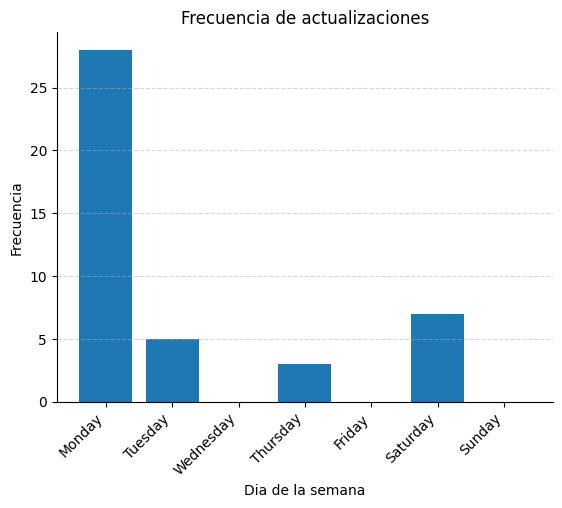

In [80]:
plt.bar(set_completo.index, set_completo["Frecuencia"])

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(rotation = 45, ha = 'right')
plt.xlabel("Dia de la semana")
plt.ylabel("Frecuencia")

plt.title("Frecuencia de actualizaciones")
plt.show()

## (2) Porcentajes de uso de la aplicación por género

Primero abrimos el archivo "perfiles.json" para acceder a los datos de los perfiles de la aplicación. Para eso utilizamos el método "read_json()" de Pandas, que nos permite generar un DataFrame a partir de los datos del archivo.

In [81]:
perfiles = pd.read_json('perfiles.json', orient= 'index')

Dentro de los datos de los perfiles, podemos encontrar los géneros "mujer", "hombre", "no binario", o muchos otros ingresados por el usuario. Con el objetivo de agrupar todos esos géneros dentro de una misma categoría, reemplazamos todos los géneros ingresados por el usuario por "otro" en el DataFrame.

In [82]:
keys_generos = perfiles['GENERO'].keys()

mis_generos = ['mujer', 'hombre', 'no binario']
for key in keys_generos:
    if perfiles['GENERO'][key] not in mis_generos:
        perfiles['GENERO'][key] = 'otro'

C:\Users\mjavi\AppData\Local\Temp\ipykernel_13020\4284490359.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perfiles['GENERO'][key] = 'otro'
C:\Users\mjavi\AppData\Local\Temp\ipykernel_13020\4284490359.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perfiles['GENERO'][key] = 'otro'
C:\Users\mjavi\AppData\Local\Temp\ipykernel_13020\4284490359.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perfiles['GENERO'][key] = 'otro'


Ahora podemos acceder a los perfiles de los usuarios que figuran haber realizado una operación en el archivo "log_system.csv" con el objetivo de contar cuantas operaciones se realizaron por género usando el método "value_counts()" de Pandas. Se guarda la información en "generos" de tipo Series.

In [83]:
generos = perfiles['GENERO'].loc[data_set['Nombre Usuario']].value_counts()

Por último, creamos el grafico de torta con "pyplot.pie()" con los datos de "generos", le damos formato, y lo mostramos en pantalla.

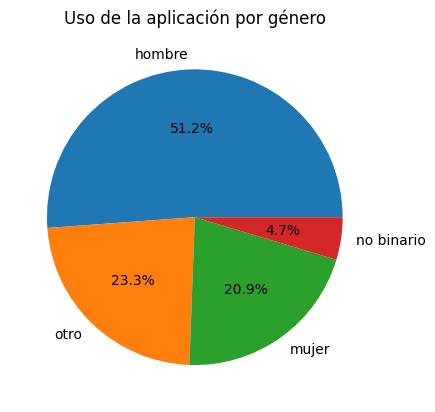

In [84]:
plt.pie(generos.values, labels= generos.index, autopct='%1.1f%%',labeldistance= 1.1)
plt.title('Uso de la aplicación por género')
plt.show()

## (3) Cantidades de cada operación realizada

Contamos las cantidades de cada operación realizada que figuran en el DataFrame creado a partir del archivo "log_system.csv" usando el método "value_counts()", lo cual resulta en la generación de una Series en "data_log".

In [85]:
data_log = data_set["Operacion"].value_counts()

Pero queremos que también aparezcan aquellas operaciones que no figuran en el archivo, indicando que se realizaron cero operaciones para cada una de ellas.

Para eso definimos una lista con todas las operaciones posibles y generamos un nuevo DataFrame llamado "total_por_operacion" con estas operaciones como índices y con la Series "data_log" como valores. Además, agregamos el valor "0" a aquellos días (indices) que no figuraban en "data_dias".

In [86]:
etiquetas_operaciones = ["Cambio en la configuracion del sistema",
                         "Nueva imagen clasificada",
                         "Modificacion de imagen previamente clasificada",
                         "Generacion de meme",
                         "Generacion de collage",
                         "Modificacion de perfil",
                         "Creacion de nuevo perfil"]

total_por_operacion = pd.DataFrame(index = etiquetas_operaciones) 

total_por_operacion["Frecuencia"] = data_log.reindex(etiquetas_operaciones, fill_value = 0)
total_por_operacion

,Frecuencia
Cambio en la configuracion del sistema,4
Nueva imagen clasificada,12
Modificacion de imagen previamente clasificada,2
Generacion de meme,7
Generacion de collage,6
Modificacion de perfil,3
Creacion de nuevo perfil,9


Finalmente, creamos el grafico de barras con "pyplot.bar()" con los datos de "total_por_operacion", le damos formato, y lo mostramos en pantalla.

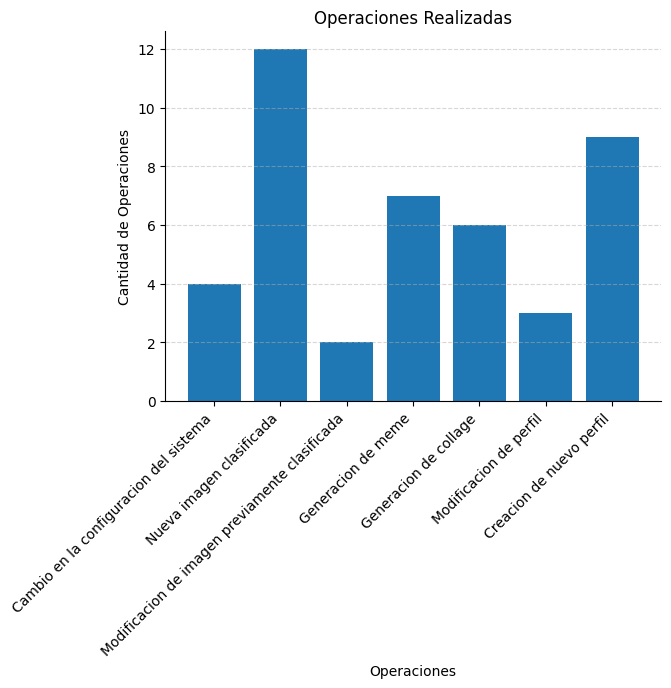

In [87]:
plt.bar(total_por_operacion.index, total_por_operacion["Frecuencia"])

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(rotation = 45, ha = 'right')

plt.xlabel("Operaciones")
plt.ylabel("Cantidad de Operaciones")
plt.title("Operaciones Realizadas")

plt.show()

## (4) Cantidades de operaciones por nick

Utilizando el método "groupby()" de Pandas, generamos un nuevo DataFrame donde los índices representan los nombres de los usuarios, y los valores la cantidad de operaciones que estos realizaron para cada una de ellas.

Luego, mostramos en pantalla el gráfico de barras horizontales utilizando la función "plot()" de Pandas.

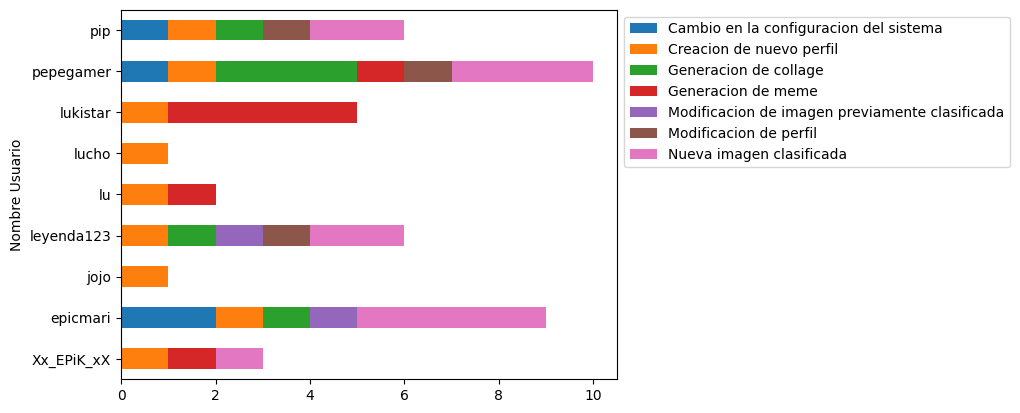

In [88]:
operaciones = data_set.groupby(['Nombre Usuario', 'Operacion']).size().unstack(fill_value=0)
operaciones.plot(kind="barh",stacked = True).legend(bbox_to_anchor = (1,1))

## (5) Rankings de las 5 imágenes más usadas para generar memes y para generar collages

Definimos el método "ranking()", que genera una Series llamada "total_por_img" a partir del DataFrame que se recibe como parámetro, la cual contiene la información de cuantas veces se utilizó cada imagen para una operación. Luego se genera un nuevo DataFrame a partir de los datos de "total_por_img", el cual se retorna al final del método.

### Ranking memes

Se genera un nuevo DataFrame llamado 'data_meme', filtrando de la columna 'Operación' sólo aquellas filas que cumplen que la operación sea 'Generación de meme'.

In [110]:
data_meme = data_set[(data_set["Operacion"] == "Generacion de meme" )]

Generamos otro DataFrame 'df_meme' que sólo contiene la columna 'Valores' del anterior 'date_meme'.

In [111]:
df_meme = pd.DataFrame(data_meme["Valores"])

A partir del método 'value_counts()' obtenemos la cantidad de veces que se repite cada valor en el DataFrame.

Reconstruimos el DataFrame a partir del método 'reset_index()'.

In [112]:
df_cantidad = df_meme.value_counts()
df_cantidad = df_cantidad.reset_index()

Se cambian los nombres de las columnas y se muestran los 5 más repetidos.


In [113]:
df_cantidad = df_cantidad.rename(columns={"Valores":"Imagen", "count":"Usos"})
df_cantidad[:5]

,Imagen,Usos
0,meme_9.png,2
1,meme_1.png,1
2,meme_10.png,1
3,meme_2.png,1
4,meme_3.png,1


### Ranking collages

Se crea un nuevo DataFrame 'data_collage', filtrando de la columna 'Operación' sólo aquellas filas que cumplen que la operación sea 'Generación de collage'.

In [93]:
data_collage = data_set[(data_set["Operacion"] == "Generacion de collage")]

De 'data_collage' generamos otro DataFrame 'df_collage', el cual contiene todas las imágenes utilizadas en diferentes columnas.

In [94]:
df_collage = data_collage["Valores"].str.split(";",expand = True)

Se fusionan todas las columnas en un nuevo DataFrame 'df', reemplazando los espacios vacíos por 'NaN' y eliminando estos ultimos.

Se elimina la columna 'variable' que contenía el número de columna al que pertenecía cada imagen en el DataFrame anterior y se resetea el index.

In [95]:
df = df_collage.melt().dropna().replace('',np.nan)

df = df.drop('variable', axis=1).dropna().reset_index(drop = True)

A partir del método 'value_counts()', obtenemos la cantidad de veces que se repite cada valor en el DataFrame. Y reconstruimos el DataFrame a partir del método 'reset_index()'.

In [96]:
df_cantidad = df.value_counts()
df_cantidad = df_cantidad.reset_index()

Se cambian los nombres de las columnas y se muestran los 5 valores más repetidos.

In [97]:
df_cantidad = df_cantidad.rename(columns={"value":"Imagen", "count":"Usos"})
df_cantidad[:5]

,Imagen,Usos
0,animal_1.png,4
1,animal_2.png,4
2,meme_6.png,4
3,meme_1.png,2
4,animal_6.png,1


## (6) Nube de palabras de los textos agregados en los collages y de los textos agregados en los memes

Definimos el método "generar_nube()", que genera una WordCloud llamada "nube_palabras" a partir de un srt que se recibe como parámetro, el cual representa todos los títulos agregados en la generación de collages. Luego se muestra en pantalla "nube_palabras" en formato de imagen.

In [98]:
def generar_nube(texto):
    '''Genera una nube de palabras y la muestra en pantalla en formato de imagen.

       Parameters
       ----------
           texto: str
               str con el texto que se va a mostrar en la nube de palabras.'''
    
    nube_palabras = WordCloud(width= 300, height= 200, random_state= 1,
                   background_color= 'White', colormap='Set2',
                   collocations= False, stopwords= stopwords).generate(texto)
    
    plt.axis("Off")
    plt.imshow(nube_palabras, interpolation = "bilinear")
    plt.show()    

### Nube de palabras de collages

Creamos el DataFrame 'texto_collage' a partir de la columa 'Texto' del DataFrame anterior 'data_collage'.

In [99]:
texto_collage = pd.DataFrame(data_collage["Textos"])

Recorriendo el DataFrame, se crea una variable str 'texto' para guardar en ella todas las palabras contenidas en 'texto_collage'.

In [100]:
texto = ''
for col in texto_collage.columns:
    texto += ' '.join(texto_collage[col].astype(str).tolist()) + ' '

Se pasa todo el contenido de 'texto' a minúscula para luego ingresar la variable 'texto' al método 'generar_nube()' para crear la nube de palabras.

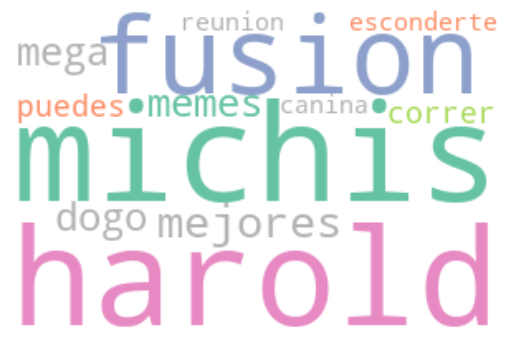

In [101]:
texto = texto.replace('None', '').lower()
generar_nube(texto)

### Nube de palabras de memes

Del DataFrame 'data_meme' usado anteriomente se forma un nuevo DataFrame 'nube_meme', el cual contiene en cada columna uno de los textos ingresados en memes y sacados de la columna 'Textos' de 'data_meme'.

In [102]:
nube_meme = data_meme["Textos"].str.split(";",expand = True)

Se fusionan todas las columnas en un nuevo DataFrame 'df', reemplazando los espacios vacíos por 'NaN' y eliminando estos últimos.

Se elimina la columna 'variable', que contenía el número de columna al que pertenecía 'Textos' en el DataFrame anterior y se resetea el index.

In [103]:
df = nube_meme.melt().dropna().replace('',np.nan)

texto_meme = df.drop('variable', axis=1).dropna().reset_index(drop = True)

Recorriendo el DataFrame, se guarda en la variable str 'texto' todas las palabras contenidas en 'texto_meme'.

In [104]:
texto = ''
for col in texto_meme.columns:
    texto += ' '.join(texto_meme[col].astype(str).tolist()) + ' '

Se pasa todo el contenido de 'texto' a minúscula para luego ingresar la variable 'texto' al método 'generar_nube()' y así crear la nube de palabras.

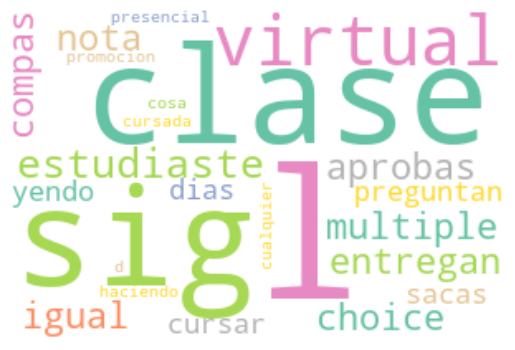

In [105]:
texto = texto.replace('None', '').lower()
generar_nube(texto)

## (7) Porcentajes según género de las personas que realizaron las operaciones:
    - Nueva imagen clasificada
    - Modificación de imagen previamente clasificada

Generamos un nuevo DataFrame con los datos de los usuarios que realizaron operaciones según la información del DataFrame "data_set" que se creó previamente.

In [106]:
lista_ope = ['Nueva imagen clasificada', 'Modificacion de imagen previamente clasificada']
operaciones = data_set.groupby(['Nombre Usuario', 'Operacion']).size().unstack()
total_operaciones = operaciones[lista_ope].dropna(how= 'all').fillna(0)
total_operaciones

Operacion,Nueva imagen clasificada,Modificacion de imagen previamente clasificada
Nombre Usuario,,
Xx_EPiK_xX,1.0,0.0
epicmari,4.0,1.0
leyenda123,2.0,1.0
pepegamer,3.0,0.0
pip,2.0,0.0


Creamos la Series "etiquetas_generos", que contiene la información de los géneros de los usuarios que realizaron alguna de las operaciones indicadas por los elementos de la lista "lista_ope".

Usando la función "value_counts()", contamos la cantidad de cada género que figura en "etiquetas_generos", y lo guardamos en otra Series llamada "total_generos".

In [107]:
etiquetas_generos = perfiles['GENERO'].loc[total_operaciones.index]
total_generos = etiquetas_generos.value_counts()

print(etiquetas_generos)
total_generos

Nombre Usuario
Xx_EPiK_xX      otro
epicmari       mujer
leyenda123    hombre
pepegamer     hombre
pip             otro
Name: GENERO, dtype: object


GENERO
otro      2
hombre    2
mujer     1
Name: count, dtype: int64

Por último, creamos el grafico de torta con "pyplot.pie()" con los valores y etiquetas de "total_generos", le damos formato, y lo mostramos en pantalla.

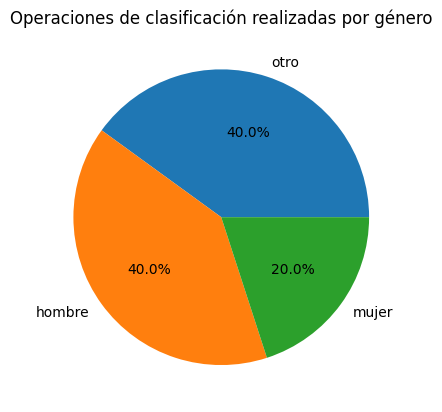

In [108]:
plt.pie(total_generos, labels= total_generos.index, autopct='%1.1f%%')
plt.title('Operaciones de clasificación realizadas por género')
plt.show()